Load in everything

In [3]:
import torch
import numpy as np
import pyvista as pv
import Ofpp
from utils.visualizer import *
pv.set_jupyter_backend('static') 

import sys
import os
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Torch_VFM')
from src.utils.mesh_utils import *
from src.utils.data_utils import get_bc_dict
from src.gauss_green import gaus_green_vfm_mesh
from src.physics.operators import *

dtype = torch.float64

def load_case_mesh(dir, bc_dict, dtype= torch.float32):
    vtk_file_reader = pv.POpenFOAMReader(dir)

    # Get Mesh
    mesh = gaus_green_vfm_mesh(vtk_file_reader, dtype=dtype)
    if bc_dict is not None:
        mesh.add_bc_conditions(bc_dict)

    # Get Ground Truth Data
    vtk_file_reader.set_active_time_value(vtk_file_reader.time_values[-1])
    vtk_file_reader.cell_to_point_creation = False
    vtk_file_reader.enable_all_patch_arrays()
    vtk_mesh = vtk_file_reader.read()[0]
    U_gt = torch.tensor(vtk_mesh['U'], dtype = dtype).unsqueeze(0).unsqueeze(0)
    return mesh, vtk_mesh, U_gt

from src.utils.data_utils import get_bc_dict # default cylinder bc list



**Base items:**

In [4]:
dir = r'C:\Users\Noahc\Downloads\c5_test\case.foam'
mesh, vtk_mesh, U_gt =  load_case_mesh(dir, bc_dict=get_bc_dict(), dtype=dtype)
nu = 0.013333333333333334
fvm_int_face_idx = mesh.mesh.internal_faces


resorting to default bc_dict, this line needs to be superseeded
Calculating face centers and areas for 37020 faces
Corrected 0 misaligned face area vectors
{'max_non_orthogonality': 43.433995038442895, 'avg_non_orthogonality': 4.755765077554514, 'max_skewness': 0.19769376516342163, 'avg_skewness': 0.005930359475314617}
 Found Patch "out" with 80 Faces
 Found Patch "sym1" with 100 Faces
 Found Patch "sym2" with 100 Faces
 Found Patch "in" with 80 Faces
 Found Patch "cylinder" with 80 Faces
 Found Patch "back" with 9200 Faces
 Found Patch "front" with 9200 Faces
Boundary faces indexed: 18840/18840 patches found
Calculating Cell2Cell at Face Linear Interpolation Weights (L2):
  min w:0.4621,               max w:0.5837,               mean w:0.5050


In [3]:
# investigate
def check_minmax(target, compare, dif):
    if len(dif.shape) == 1:
        target = target.unsqueeze(-1)
        compare = compare.unsqueeze(-1)
        dif = dif.unsqueeze(-1)
    names = ['x-axis', 'y-axis', 'z-axis']
    for i in range(dif.shape[-1]):
        print(f'axis: {names[i]}')
        max_idx = torch.argmax(dif, dim=0)[i]
        min_idx = torch.argmin(dif, dim=0)[i]
        print('Maximum dif | target:', target[max_idx][i].item(), 'vs:', compare[max_idx][i].item(), 'difference', dif[max_idx][i].item())
        print('Minimum dif |target:', target[min_idx][i].item(), 'vs:', compare[min_idx][i].item(), 'difference', dif[min_idx][i].item())

## Aligning OpenFoam Faces + Owner/Neighbour with our Pytorch FVM method

**ofpp objects:**

In [4]:
ofpp_mesh = Ofpp.FoamMesh(r'C:\Users\Noahc\Downloads\c5_test')
ofpp_fc = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\faceCentresField')
ofpp_nf = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\n_vec')
ofpp_Sfmag = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\magSf')
ofpp_Sf = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\Sf')
ofpp_delta = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\delta')
ofpp_k = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\k')

# For non-orthogonal calculation
ofpp_u_grad_face = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\faceGrad')
ofpp_nonOrthDeltaCoeffs = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\constant\nonOrthDeltaCoeffs')
ofpp_nonOrthCorrectionVectors = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\constant\nonOrthCorrectionVectors')

U_gt = torch.tensor(Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\U'),dtype=dtype)

In [5]:
def reorder_B_to_match_A(A, B):
    # Build a mapping from tuple(row) in B to its index
    row_to_index = {tuple(np.sort(row)): i for i, row in enumerate(B)}

    # Use this mapping to reorder B
    indices = [row_to_index[tuple(row)] for row in A]

    # Reorder B accordingly
    return indices

In [6]:
Ofpp_sorted_faces = np.array([np.sort(face) for face in ofpp_mesh.faces])
fvm_sorted_faces = np.array([np.sort(face) for face in mesh.mesh.faces])
# Example usage
fvm_to_ofpp_all_faces_idx = reorder_B_to_match_A(Ofpp_sorted_faces, mesh.mesh.faces)
fvm_to_ofpp_int_faces_idx = reorder_B_to_match_A(Ofpp_sorted_faces[:18180], [mesh.mesh.faces[i] for i in fvm_int_face_idx])
ofpp_to_fvm_all_faces_idx = reorder_B_to_match_A(fvm_sorted_faces, ofpp_mesh.faces)
ofpp_to_fvm_int_faces_idx = reorder_B_to_match_A(fvm_sorted_faces[fvm_int_face_idx], ofpp_mesh.faces[:18180])

In [7]:
fvm_sorted_faces[fvm_int_face_idx]

array([[    0,     1,   231,   232],
       [   21,    22,   252,   253],
       [    1,    22,   232,   253],
       ...,
       [14468, 14768, 18566, 18836],
       [14469, 14769, 18567, 18837],
       [14470, 14770, 18568, 18838]])

check that everything matches:

In [8]:
# Difference Between Face Centers
dif = torch.tensor(ofpp_fc[ofpp_to_fvm_int_faces_idx]) - mesh.mesh.face_centers[fvm_int_face_idx]
dif *= 100/mesh.mesh.face_centers[fvm_int_face_idx]
dif[torch.where(torch.isnan(dif))] = 0
print(f'max dif: {dif.max().item():.6f}%, min dif:{dif.min().item():.6f}%, mean dif:{dif.mean().item():.6f}%')

max dif: 0.000009%, min dif:-0.000008%, mean dif:0.000000%


In [9]:
# Difference Between Normal Vectors
target = torch.tensor(ofpp_nf[ofpp_to_fvm_int_faces_idx])[...,:2]
compare = mesh.mesh.face_normal_unit_vectors[fvm_int_face_idx][...,:2]
dif = (target-compare)*100/compare
dif[torch.where(torch.isnan(dif))] = 0
print(f'max dif: {dif.max().item():.6f}%, min dif:{dif.min().item():.6f}%, mean dif:{dif.mean().item():.6f}%')

max dif: 0.151588%, min dif:-0.363832%, mean dif:-0.000031%


In [10]:
# Difference Between Face Area Magnitudes
target = torch.tensor(ofpp_Sfmag[ofpp_to_fvm_int_faces_idx])
compare = mesh.mesh.face_areas_mag[fvm_int_face_idx]
dif = (target-compare)*100/compare
dif[torch.where(torch.isnan(dif))] = 0
print(f'max dif: {dif.max().item():.6f}%, min dif:{dif.min().item():.6f}%, mean dif:{dif.mean().item():.6f}%')

max dif: 0.000205%, min dif:-0.000262%, mean dif:0.000000%


In [11]:
# Difference Between Face Area Vectors
target = torch.tensor(ofpp_Sf[ofpp_to_fvm_int_faces_idx])[...,:2]
compare = mesh.mesh.face_areas[fvm_int_face_idx][...,:2]
dif = (target-compare)
print(f'max dif: {dif.max().item():.4f}, min dif:{dif.min().item():.4f}, mean dif:{dif.mean().item():.4f}')
dif *=100/compare
dif[torch.where(torch.isnan(dif))[0]] = 0
dif[torch.where(torch.isinf(dif))[0]] = 0
print(f'max dif: {dif.max().item():.6f}%, min dif:{dif.min().item():.6f}%, mean dif:{dif.mean().item():.6f}%')

max dif: 0.0000, min dif:-0.0000, mean dif:0.0000
max dif: 0.151591%, min dif:-0.363832%, mean dif:-0.000031%


Areas do align but Normal Vectors do not align. Must be because of direction

## Checking for Vector Alignment Between the two methods

In [12]:
def alighnment_check (based_vector, checked_vector):
    alignment = torch.einsum('fd,fd->f', based_vector, checked_vector)
    misalignment_idx = torch.where(alignment < 0)[0]
    print(len(misalignment_idx), 'vectors maligned')
    return misalignment_idx

possible reasons. the max displacement could be because of the precision of the error. If the vector is already very small. We might see a higher percentage change in it. This is confirmed below. We can move on from the normal vector...

In [13]:
# Difference Between Face Area Magnitudes
target = torch.tensor(ofpp_nf[ofpp_to_fvm_int_faces_idx], dtype=dtype)[...,:2]
compare = mesh.mesh.face_normal_unit_vectors[fvm_int_face_idx][...,:2]
malign_idx = alighnment_check(compare, target)
target[malign_idx] *= -1.0
dif = (target-compare)
print(f'max dif: {dif.max().item():.4f}, min dif:{dif.min().item():.4f}, mean dif:{dif.mean().item():.4f}')
dif *=100/compare
dif[torch.where(torch.isnan(dif))[0]] = 0
dif[torch.where(torch.isinf(dif))[0]] = 0
print(f'max dif: {dif.max().item():.6f}%, min dif:{dif.min().item():.6f}%, mean dif:{dif.mean().item():.6f}%')
check_minmax(target, compare, dif)

0 vectors maligned
max dif: 0.0000, min dif:-0.0000, mean dif:0.0000
max dif: 0.151588%, min dif:-0.363832%, mean dif:-0.000031%
axis: x-axis
Maximum dif | target: 0.0087220486 vs: 0.008714471299804249 difference 0.08695077343271616
Minimum dif |target: 0.0019543918 vs: 0.0019615284617091415 difference -0.36383166741935064
axis: y-axis
Maximum dif | target: 0.0011202178 vs: 0.0011185222571919488 difference 0.15158775761046528
Minimum dif |target: -0.0019225885 vs: -0.0019261290192054325 difference -0.1838152673123164


Here we prove that our normal vector is indeed the `face_areas` magnitude.

In [14]:
target = (mesh.mesh.face_areas/mesh.mesh.face_areas_mag.unsqueeze(-1))[fvm_int_face_idx][...,:2]
compare = mesh.mesh.face_normal_unit_vectors[fvm_int_face_idx][...,:2]
malign_idx = alighnment_check(compare, target)
target[malign_idx] *= -1.0
dif = (target-compare)
print(f'max dif: {dif.max().item():.4f}, min dif:{dif.min().item():.4f}, mean dif:{dif.mean().item():.4f}')
dif *=100/compare
dif[torch.where(torch.isnan(dif))[0]] = 0
dif[torch.where(torch.isinf(dif))[0]] = 0
print(f'max dif: {dif.max().item():.6f}%, min dif:{dif.min().item():.6f}%, mean dif:{dif.mean().item():.6f}%')

0 vectors maligned
max dif: 0.0000, min dif:0.0000, mean dif:0.0000
max dif: 0.000000%, min dif:0.000000%, mean dif:0.000000%


### Comparison of non-Orthogonal Vectors

In [15]:
d = mesh.mesh.cell_center_vectors
d_mag = torch.norm(d, dim=-1, keepdim=False)
delta = d * (1/torch.max(torch.einsum('fd,fd->f',mesh.mesh.face_normal_unit_vectors,d),0.5*d_mag)).unsqueeze(-1)
delta_mag = torch.norm(delta, dim=-1, keepdim=False) 
k_vector = mesh.mesh.face_normal_unit_vectors - delta

In [16]:
# Difference Between Delta Vectors
target = torch.tensor(ofpp_delta[ofpp_to_fvm_int_faces_idx], dtype=dtype)[...,:2]
compare = delta[fvm_int_face_idx][...,:2]
malign_idx = alighnment_check(compare, target)
target[malign_idx] *= -1.0
dif = (target-compare)
print(f'max dif: {dif.max().item():.4f}, min dif:{dif.min().item():.4f}, mean dif:{dif.mean().item():.4f}')
check_minmax(target, compare, dif)
print('PERECENTAGES')
dif *=100/compare
dif[torch.where(torch.isnan(dif))[0]] = 0
dif[torch.where(torch.isinf(dif))[0]] = 0
print(f'max dif: {dif.max().item():.6f}%, min dif:{dif.min().item():.6f}%, mean dif:{dif.mean().item():.6f}%')
check_minmax(target, compare, dif)

0 vectors maligned
max dif: 0.0000, min dif:-0.0000, mean dif:-0.0000
axis: x-axis
Maximum dif | target: 0.11664194 vs: 0.1166382342409004 difference 3.7057590995953626e-06
Minimum dif |target: -0.060589502 vs: -0.06058659325650654 difference -2.9087434934640943e-06
axis: y-axis
Maximum dif | target: 0.045493895 vs: 0.04549096663016677 difference 2.928369833232747e-06
Minimum dif |target: -0.045493895 vs: -0.04549096663016671 difference -2.928369833288258e-06
PERECENTAGES
max dif: 400.000135%, min dif:-600.000135%, mean dif:-12.550414%
axis: x-axis
Maximum dif | target: 8.768581e-15 vs: 1.7537157273972668e-15 difference 400.0001347432556
Minimum dif |target: -8.768581e-15 vs: 1.75371572739727e-15 difference -600.0001347432549
axis: y-axis
Maximum dif | target: -7.1467769e-15 vs: -1.7866936936603043e-15 difference 300.0001189548488
Minimum dif |target: -1.5866254e-14 vs: 3.966562406692602e-15 difference -500.00011025238337


In [17]:
# Difference Between K Vectors
target = torch.tensor(ofpp_k[ofpp_to_fvm_int_faces_idx], dtype=dtype)[...,:2]
compare = k_vector[fvm_int_face_idx][...,:2]
malign_idx = alighnment_check(compare, target)
target[malign_idx] *= -1.0
dif = (target-compare)
print(f'max dif: {dif.max().item():.4f}, min dif:{dif.min().item():.4f}, mean dif:{dif.mean().item():.4f}')
check_minmax(target, compare, dif)
print('\nPERECENTAGES')
dif *=100/compare
dif[torch.where(torch.isnan(dif))[0]] = 0
dif[torch.where(torch.isinf(dif))[0]] = 0
print(f'max dif: {dif.max().item():.6f}%, min dif:{dif.min().item():.6f}%, mean dif:{dif.mean().item():.6f}%')
check_minmax(target, compare, dif)

1597 vectors maligned
max dif: 0.0000, min dif:-0.0000, mean dif:-0.0000
axis: x-axis
Maximum dif | target: 0.010792827 vs: 0.010785299168380943 difference 7.527831619056832e-06
Minimum dif |target: -0.010792827 vs: -0.010785299168380943 difference -7.527831619056832e-06
axis: y-axis
Maximum dif | target: -0.035267433 vs: -0.035275593468038845 difference 8.160468038843904e-06
Minimum dif |target: 0.035267433 vs: 0.035275593468038845 difference -8.160468038843904e-06

PERECENTAGES
max dif: 3100.000019%, min dif:-3100.000024%, mean dif:-1.779051%
axis: x-axis
Maximum dif | target: 3.5527137e-15 vs: 1.1102230246251565e-16 difference 3100.0000190948113
Minimum dif |target: 3.4416914e-15 vs: -2.220446049250313e-16 difference -1650.000010656424
axis: y-axis
Maximum dif | target: -3.663736e-15 vs: -2.220446049250313e-16 difference 1550.000008438387
Minimum dif |target: -3.3306691e-15 vs: 1.1102230246251565e-16 difference -3100.000023530885


Here it looks like the biggest of these maligned k vectors can be considered a zero vector anyway. So direction does not matter.

In [18]:
target[malign_idx].max()

tensor(2.0759e-07, dtype=torch.float64)

## Comparison of Uncorrected Surface Gradients

In [19]:
grad_U_gt_corrected = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\snGrad(U)_corrected')
grad_U_gt_uncorrected = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\snGrad(U)_uncorrected')

In [20]:
# Difference Between Underlying data
target = torch.tensor(grad_U_gt_uncorrected[ofpp_to_fvm_int_faces_idx], dtype=dtype)[...,:2]
compare = torch.tensor(grad_U_gt_corrected[ofpp_to_fvm_int_faces_idx], dtype=dtype)[...,:2]
malign_idx = alighnment_check(compare, target)
target[malign_idx] *= -1.0
dif = (target-compare)
print(f'max dif: {dif.max().item():.4f}, min dif:{dif.min().item():.4f}, mean dif:{dif.mean().item():.4f}')
check_minmax(target, compare, dif)
print('\nPERECENTAGES')
dif *=100/compare
dif[torch.where(torch.isnan(dif))[0]] = 0
dif[torch.where(torch.isinf(dif))[0]] = 0
print(f'max dif: {dif.max().item():.6f}%, min dif:{dif.min().item():.6f}%, mean dif:{dif.mean().item():.6f}%')
check_minmax(target, compare, dif)

14 vectors maligned
max dif: 0.2642, min dif:-0.5011, mean dif:-0.0006
axis: x-axis
Maximum dif | target: 0.91165772 vs: 0.69036112 difference 0.22129659999999995
Minimum dif |target: 0.40369628 vs: 0.90475775 difference -0.50106147
axis: y-axis
Maximum dif | target: 0.39692528 vs: 0.13274406 difference 0.26418122
Minimum dif |target: -0.040722839 vs: 0.31716111 difference -0.35788394900000003

PERECENTAGES
max dif: 35658.236325%, min dif:-269749.566434%, mean dif:-18.427577%
axis: x-axis
Maximum dif | target: -0.36610044 vs: -0.0010238213 difference 35658.23632503055
Minimum dif |target: 0.042506444 vs: -1.5763587e-05 difference -269749.5664343401
axis: y-axis
Maximum dif | target: 0.0031043182 vs: 8.8396769e-06 difference 35018.00527460455
Minimum dif |target: -0.0099735688 vs: 1.1222093e-05 difference -88974.40872215193


**Our snGRAD scheme** (Implicit Part i.e. non-corrected).
Using the ground truth cell gradients as the volumetric solution.

In [21]:
face_gradients_implicit_gt = (U_gt[mesh.mesh.face_neighbors[fvm_int_face_idx], :] - U_gt[mesh.mesh.face_owners[fvm_int_face_idx],:])
face_gradients_implicit_gt *= (delta_mag/mesh.d_mag)[fvm_int_face_idx].unsqueeze(-1)
print('face_gradients_implicit_gt', face_gradients_implicit_gt.shape)

face_gradients_implicit_gt torch.Size([18180, 3])


compare with the OpenFoam snGrad uncorrected function output

In [22]:
# Difference Between Face Area Magnitudes
target = torch.tensor(grad_U_gt_uncorrected[ofpp_to_fvm_int_faces_idx], dtype=dtype)[...,:2]
compare = face_gradients_implicit_gt[...,:2]
malign_idx = alighnment_check(compare, target)
target[malign_idx] *= -1.0
dif = (target-compare)
print(f'max dif: {dif.max().item():.4f}, min dif:{dif.min().item():.4f}, mean dif:{dif.mean().item():.4f}')
check_minmax(target, compare, dif)
print('\nPERECENTAGES')
dif *=100/compare
dif[torch.where(torch.isnan(dif))[0]] = 0
dif[torch.where(torch.isinf(dif))[0]] = 0
print(f'max dif: {dif.max().item():.6f}%, min dif:{dif.min().item():.6f}%, mean dif:{dif.mean().item():.6f}%')
check_minmax(target, compare, dif)

0 vectors maligned
max dif: 0.0000, min dif:-0.0000, mean dif:-0.0000
axis: x-axis
Maximum dif | target: -7.3575642 vs: -7.357566152870985 difference 1.9528709849225834e-06
Minimum dif |target: -6.9447338 vs: -6.9447315464605195 difference -2.253539480356892e-06
axis: y-axis
Maximum dif | target: 3.7857 vs: 3.7856988229588073 difference 1.1770411925127178e-06
Minimum dif |target: -3.4479909 vs: -3.4479898318009 difference -1.0681991002847724e-06

PERECENTAGES
max dif: 0.000208%, min dif:-0.000218%, mean dif:-0.000000%
axis: x-axis
Maximum dif | target: 0.044665004 vs: 0.04466491094012459 difference 0.00020835119437394103
Minimum dif |target: 0.10059256 vs: 0.10059277383720061 difference -0.00021257709918544692
axis: y-axis
Maximum dif | target: 0.36468147 vs: 0.36468071431073246 difference 0.00020721942178356497
Minimum dif |target: 0.22886053 vs: 0.2288610292089112 difference -0.00021812753045227087


**Field Statistics**

In [23]:
target = torch.tensor(grad_U_gt_uncorrected[ofpp_to_fvm_int_faces_idx], dtype=dtype)[...,:2]
compare = face_gradients_implicit_gt[...,:2]
print(f'target field mean: {target.mean():.6f} max: {target.max():.6f} min: {target.min():.6f}\ncomparison field mean: {compare.mean():.6f} max: {compare.max():.6f} min: {compare.min():.6f}' )

target field mean: 0.019802 max: 5.922160 min: -7.357564
comparison field mean: 0.019802 max: 5.922160 min: -7.357566


These are relatively the same. Especially when compared to the corrected version:

In [24]:
target = torch.tensor(grad_U_gt_uncorrected[ofpp_to_fvm_int_faces_idx], dtype=dtype)[...,:2]
compare = torch.tensor(grad_U_gt_corrected[ofpp_to_fvm_int_faces_idx], dtype=dtype)[...,:2]
print(f'target field mean: {target.mean():.6f} max: {target.max():.6f} min: {target.min():.6f}\ncomparison field mean: {compare.mean():.6f} max: {compare.max():.6f} min: {compare.min():.6f}' )

target field mean: 0.019802 max: 5.922160 min: -7.357564
comparison field mean: 0.020424 max: 5.923646 min: -7.357302


**Comparing to Laplacian**

In [25]:
lapU_gt_uncorrected = torch.tensor(vtk_mesh['lapU'], dtype = dtype)
lapU_gt_corrected = torch.tensor(vtk_mesh['lapU_corrected'], dtype = dtype)

In [26]:
ofpp_calc_lapU_uncorrected = torch.zeros((mesh.mesh.n_cells, mesh.mesh.dim), dtype=dtype)
grad_U_gt_uncorrected_ordered = torch.tensor(grad_U_gt_uncorrected[ofpp_to_fvm_int_faces_idx], dtype=dtype)
grad_U_gt_uncorrected_ordered *= mesh.mesh.face_areas_mag[fvm_int_face_idx].reshape(-1,1)
ofpp_calc_lapU_uncorrected.index_add_(0, mesh.mesh.face_owners[fvm_int_face_idx], grad_U_gt_uncorrected_ordered)
ofpp_calc_lapU_uncorrected.index_add_(0, mesh.mesh.face_neighbors[fvm_int_face_idx], -grad_U_gt_uncorrected_ordered)
ofpp_calc_lapU_uncorrected *= nu/mesh.mesh.cell_volumes.reshape(-1,1)

The main differences here are due to the boundaries which we are not enforcing in this instance. By manually adjusting the field we can see here that the field matches almost 100% well.

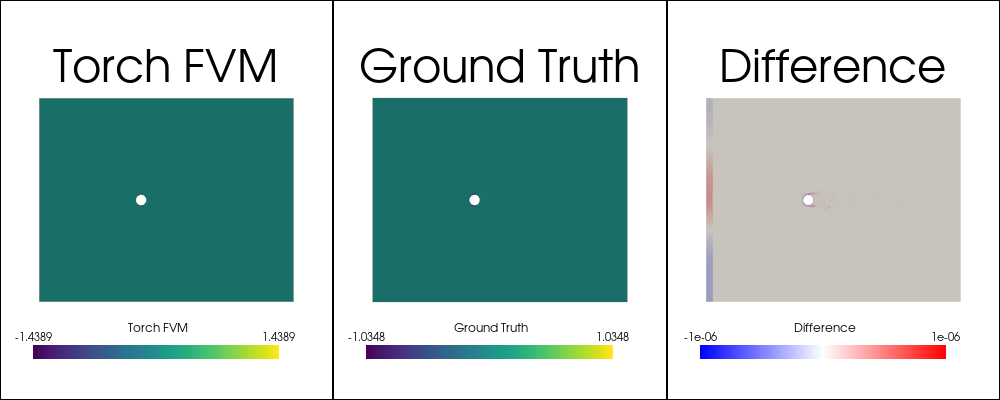

In [27]:
plot_comparison(vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction=ofpp_calc_lapU_uncorrected,
                    ground_truth = lapU_gt_uncorrected,
                    clims3=[-0.000001,0.000001]
                    )

We will compare to our method now too:

In [28]:
fvm_calc_lapU_uncorrected = torch.zeros((mesh.mesh.n_cells, mesh.mesh.dim), dtype=dtype)
grad_U_fvm_uncorrected = face_gradients_implicit_gt.clone()
grad_U_fvm_uncorrected *= mesh.mesh.face_areas_mag[fvm_int_face_idx].reshape(-1,1)
fvm_calc_lapU_uncorrected.index_add_(0, mesh.mesh.face_owners[fvm_int_face_idx], grad_U_fvm_uncorrected)
fvm_calc_lapU_uncorrected.index_add_(0, mesh.mesh.face_neighbors[fvm_int_face_idx], -grad_U_fvm_uncorrected)
fvm_calc_lapU_uncorrected *= nu/mesh.mesh.cell_volumes.reshape(-1,1)

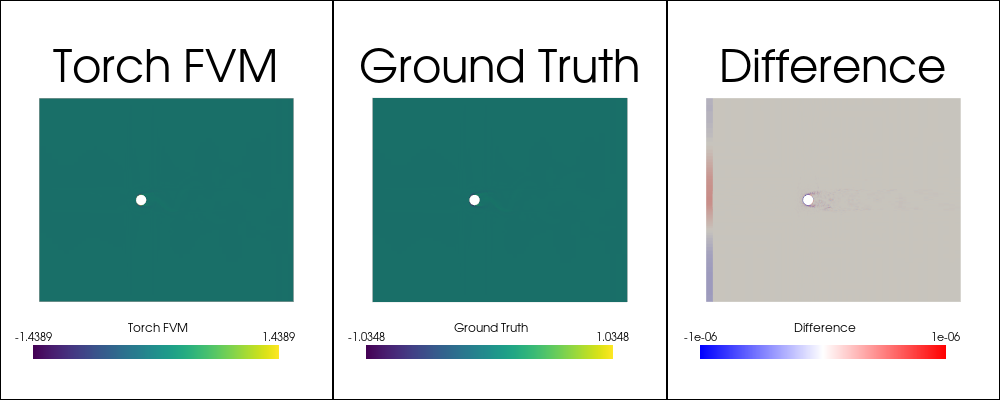

In [29]:
plot_comparison(vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction=fvm_calc_lapU_uncorrected,
                    ground_truth = lapU_gt_uncorrected,
                    clims3=[-0.000001,0.000001]
                    )

## Comparison of Corrected Surface Gradients

First lets reverse engineer the correction...

In [30]:
grad_U_gt_correction = grad_U_gt_corrected - grad_U_gt_uncorrected

This should match (on a cell basis), the laplacian corrections:

In [31]:
lapU_gt_correction = lapU_gt_corrected - lapU_gt_uncorrected
cell_total_flux_correction = lapU_gt_correction*mesh.mesh.cell_volumes.unsqueeze(-1)/nu

Where:
$$
\text{cell\_total\_flux\_correction} = \sum ((\mathbf{n}_f - \boldsymbol{\Delta}_f) \cdot \boldsymbol{\nabla} \mathbf{U}_f)
$$

In [32]:
ofpp_calc_grad_correction = torch.zeros((mesh.mesh.n_cells, mesh.mesh.dim), dtype=dtype)
grad_U_gt_correction_t = torch.tensor(grad_U_gt_correction[ofpp_to_fvm_int_faces_idx], dtype=dtype)
grad_U_gt_correction_t *= mesh.mesh.face_areas_mag[fvm_int_face_idx].reshape(-1,1)
ofpp_calc_grad_correction.index_add_(0, mesh.mesh.face_owners[fvm_int_face_idx], grad_U_gt_correction_t)
ofpp_calc_grad_correction.index_add_(0, mesh.mesh.face_neighbors[fvm_int_face_idx], -grad_U_gt_correction_t)
print('ofpp_calc_grad_correction',ofpp_calc_grad_correction.shape)

ofpp_calc_grad_correction torch.Size([9200, 3])


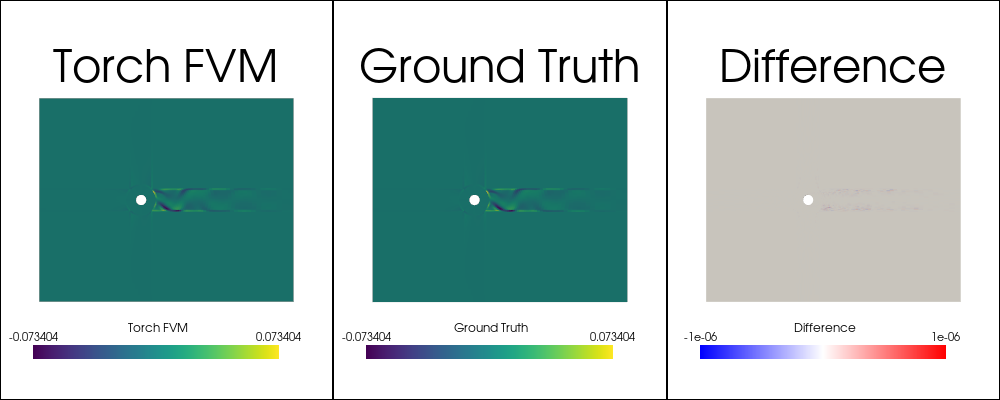

In [33]:
plot_comparison(vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction=ofpp_calc_grad_correction,
                    ground_truth = cell_total_flux_correction,
                    clims3=[-0.000001,0.000001]
                    )

ok. So we need to get both $\mathbf{n}_f$, $\boldsymbol{\Delta}_f$ and $\boldsymbol{\nabla} \mathbf{U}_f$ to match with OpenFoam.

The k and delta vectors we have printed out from OpenFoam were calculated manually in C++ and are not part of the mesh. We need to find a way to get these to match. As using our own K vector and interpolated gradient does not match.

**Non-Orthogonal Delta Coefficient**

In [34]:
ofpp_nonOrthDeltaCoeffs_t = torch.tensor(ofpp_nonOrthDeltaCoeffs, dtype=dtype)
ofpp_u_grad_face_t = torch.tensor(ofpp_u_grad_face, dtype=dtype)
ofpp_nonOrthCorrectionVectors_t = torch.tensor(ofpp_nonOrthCorrectionVectors, dtype=dtype)

Now we have found openfoams correction vector `k` using the following:
```
const surfaceVectorField& nonOrthCorrectionVectors = mesh.nonOrthCorrectionVectors();
```
And better yet it appears to match. Now according to this line in the snGrad Scheme, we just need to dot interpolate.

```
linear<typename outerProduct<vector, Type>::type>(mesh).dotInterpolate
(
    mesh.nonOrthCorrectionVectors(),
    gradScheme<Type>::New(...)().grad(vf, ...)
)
```

In [35]:
# Difference Between K Vectors
target = ofpp_nonOrthCorrectionVectors_t[ofpp_to_fvm_int_faces_idx][...,:2]
compare = k_vector[fvm_int_face_idx][...,:2]
malign_idx = alighnment_check(compare, target)
target[malign_idx] *= -1.0
dif = (target-compare)
print(f'max dif: {dif.max().item():.4f}, min dif:{dif.min().item():.4f}, mean dif:{dif.mean().item():.4f}')
check_minmax(target, compare, dif)
print('\nPERECENTAGES')
dif *=100/compare
dif[torch.where(torch.isnan(dif))[0]] = 0
dif[torch.where(torch.isinf(dif))[0]] = 0
print(f'max dif: {dif.max().item():.6f}%, min dif:{dif.min().item():.6f}%, mean dif:{dif.mean().item():.6f}%')
check_minmax(target, compare, dif)

1598 vectors maligned
max dif: 0.0000, min dif:-0.0000, mean dif:-0.0000
axis: x-axis
Maximum dif | target: 0.010792827 vs: 0.010785299168380943 difference 7.527831619056832e-06
Minimum dif |target: -0.010792827 vs: -0.010785299168380943 difference -7.527831619056832e-06
axis: y-axis
Maximum dif | target: -0.035267433 vs: -0.035275593468038845 difference 8.160468038843904e-06
Minimum dif |target: 0.035267433 vs: 0.035275593468038845 difference -8.160468038843904e-06

PERECENTAGES
max dif: 3100.000019%, min dif:-3100.000024%, mean dif:-1.707121%
axis: x-axis
Maximum dif | target: 3.5527137e-15 vs: 1.1102230246251565e-16 difference 3100.0000190948113
Minimum dif |target: 3.4416914e-15 vs: -2.220446049250313e-16 difference -1650.000010656424
axis: y-axis
Maximum dif | target: -3.7747583e-15 vs: -2.220446049250313e-16 difference 1600.0000073293688
Minimum dif |target: -3.3306691e-15 vs: 1.1102230246251565e-16 difference -3100.000023530885


In [36]:
# Method 1
vfm_calc_grad_correction =  torch.einsum('fd,fde->fe', ofpp_nonOrthCorrectionVectors_t, ofpp_u_grad_face_t.reshape(-1,3,3))

In [37]:
# Method 2
dot_product = torch.sum(ofpp_nonOrthCorrectionVectors_t.unsqueeze(1) * ofpp_u_grad_face_t.reshape(-1,3,3), dim=2)
explicit_correction = torch.sum(dot_product, dim=1)
vfm_calc_grad_correction = explicit_correction.unsqueeze(-1)*torch.tensor(ofpp_nf, dtype=dtype)

## Pure Openfoam

In [38]:
sngrad_correction = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\correction_v1')
sngrad_k_vector = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\constant\nonOrthCorrectionVectors')
sngrad_uncorrected = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\snGrad(U)_uncorrected')
sngrad_corrected = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\snGrad(U)_corrected')
gradUf_explicit = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\gradUf_explicit')
lapU_corrected = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\lapU_corrected')
target_correction = sngrad_corrected - sngrad_uncorrected

In [39]:
print('sngrad_correction', sngrad_correction[1761])
print('sngrad_k_vector', sngrad_k_vector[1761])
print('sngrad_uncorrected', sngrad_uncorrected[1761])
print('sngrad_corrected', sngrad_corrected[1761])
print('gradUf_explicit', gradUf_explicit[1761][:3],'...')

sngrad_correction [ 4.8894202e-02 -8.1174229e-03 -1.4007338e-20]
sngrad_k_vector [-6.5041599e-01  6.8800146e-01 -6.0065884e-16]
sngrad_uncorrected [ 6.7661691e-02 -1.1903176e-01  2.3945423e-21]
sngrad_corrected [ 1.1655589e-01 -1.2714918e-01 -1.1612796e-20]
gradUf_explicit [ 4.0865423e-02 -9.7066379e-02  7.1088416e-20] ...


In [40]:
print(sngrad_k_vector[1761] @ gradUf_explicit[1761].reshape(3, 3))

[ 4.88942012e-02 -8.11742669e-03 -1.40073375e-20]


This works!!!

In [41]:
idx = 1761
print(np.einsum('fi,fij->fj', sngrad_k_vector, gradUf_explicit.reshape(-1,3, 3))[idx])
print('compared to')
print(target_correction[idx])
print(sngrad_correction[idx])

[ 4.88942012e-02 -8.11742669e-03 -1.40073375e-20]
compared to
[ 4.88941990e-02 -8.11742000e-03 -1.40073383e-20]
[ 4.8894202e-02 -8.1174229e-03 -1.4007338e-20]


In [42]:
ofpp_nonOrthCorrectionVectors_t[1761], sngrad_k_vector[1761]

(tensor([-6.5042e-01,  6.8800e-01, -6.0066e-16], dtype=torch.float64),
 array([-6.5041599e-01,  6.8800146e-01, -6.0065884e-16]))

In [43]:
ofpp_u_grad_face_t[1761][:3],'...', gradUf_explicit[1761][:3],'...'

(tensor([ 4.0865e-02, -9.7066e-02,  7.1088e-20], dtype=torch.float64),
 '...',
 array([ 4.0865423e-02, -9.7066379e-02,  7.1088416e-20]),
 '...')

In [44]:
vfm_calc_grad_correction =  torch.einsum('fd,fde->fe', ofpp_nonOrthCorrectionVectors_t, ofpp_u_grad_face_t.reshape(-1,3,3))

so this was originally good... ? puzzling

In [45]:
dif = vfm_calc_grad_correction - target_correction
print(dif.max().item(),dif.min().item(),dif.mean().item())

9.096626988128187e-08 -9.5997577349835e-08 3.499341801015149e-12


In [46]:
vfm_calc_grad_correction[idx] - target_correction[idx]

tensor([ 2.2046e-09, -6.6878e-09,  8.0012e-28], dtype=torch.float64)

In [47]:
new_grad_correction = torch.zeros((mesh.mesh.n_cells, mesh.mesh.dim), dtype=dtype)
vfm_calc_grad_correction_t = vfm_calc_grad_correction[ofpp_to_fvm_int_faces_idx].clone()
vfm_calc_grad_correction_t *= mesh.mesh.face_areas_mag[fvm_int_face_idx].reshape(-1,1)
new_grad_correction.index_add_(0, mesh.mesh.face_owners[fvm_int_face_idx], vfm_calc_grad_correction_t)
new_grad_correction.index_add_(0, mesh.mesh.face_neighbors[fvm_int_face_idx], -vfm_calc_grad_correction_t)
print('ofpp_calc_grad_correction',new_grad_correction.shape)

ofpp_calc_grad_correction torch.Size([9200, 3])


Comparing to `ofpp_calc_grad_correction`

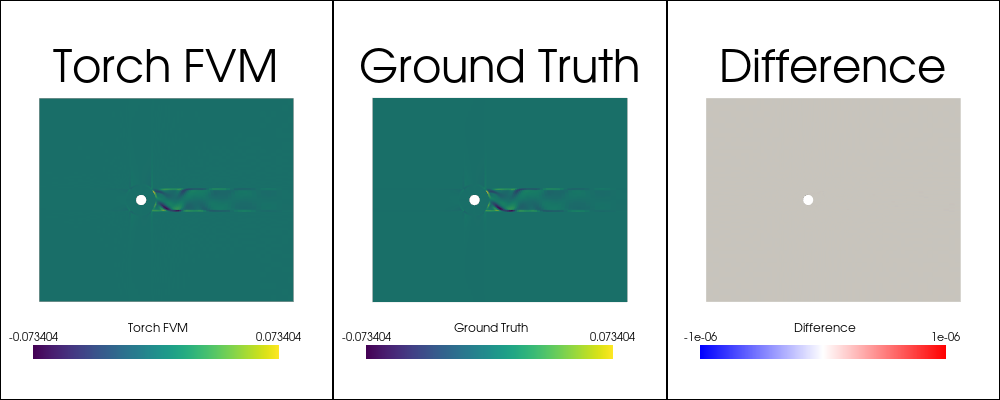

In [48]:
plot_comparison(vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction=new_grad_correction,
                    ground_truth = ofpp_calc_grad_correction,
                    clims3=[-0.000001,0.000001]
                    )

Comparing to `cell_total_flux_correction`

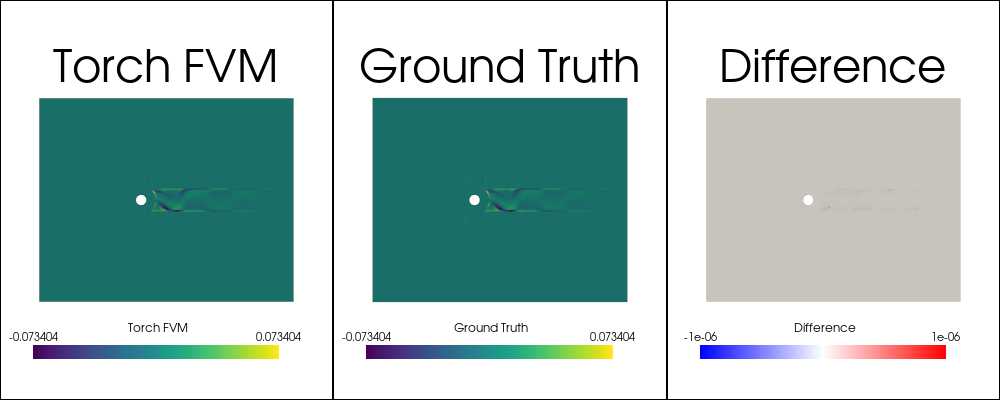

In [49]:
plot_comparison(vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction=new_grad_correction,
                    ground_truth = cell_total_flux_correction,
                    clims3=[-0.000001,0.000001]
                    )

**Now lets calculate it using our torch fvm objects instead.**

In [50]:
divergence, gradient = Divergence_Operator.caclulate(mesh, U_gt.unsqueeze(0).unsqueeze(0))
gradient_at_face = interpolate_to_faces(mesh, gradient)

In [51]:
def interpolate_to_faces(self, field: torch.Tensor) -> torch.Tensor:
        
    # Get field shape
    assert len(field.shape) == 4
    batch_size = field.shape[0]
    time_size = field.shape[1]
    channel_size = field.shape[-1]
    
    # Initialize face values
    face_values = torch.zeros((batch_size, time_size, self.mesh.num_internal_faces, channel_size), device=field.device)
        
    # Interpolate for internal faces
    idx = self.mesh.internal_faces
    face_values = field[:,:,self.mesh.face_owners[idx],...]*(self.internal_face_weights).reshape(1,1,-1,1)  + \
                                field[:,:,self.mesh.face_neighbors[idx],...]*(1-self.internal_face_weights).reshape(1,1,-1,1)
    return face_values

In [52]:
grad_correction2 =  torch.einsum('fd,fde->fe', k_vector[fvm_int_face_idx], gradient_at_face.reshape(-1,3,3))
print((grad_correction2 - vfm_calc_grad_correction[ofpp_to_fvm_int_faces_idx]).mean())
difference = gradient_at_face[0,0,fvm_to_ofpp_int_faces_idx,:] - ofpp_u_grad_face_t
print(difference.min(), difference.max(), difference.mean())

tensor(-8.6847e-11, dtype=torch.float64)
tensor(-0.0007, dtype=torch.float64) tensor(3.1473e-06, dtype=torch.float64) tensor(-6.7086e-07, dtype=torch.float64)


Why is there an an error between these two now?

In [53]:
new_grad_correction2 = torch.zeros((mesh.mesh.n_cells, mesh.mesh.dim), dtype=dtype)
vfm_calc_grad_correction_t2 = grad_correction2.clone() #vfm_calc_grad_correction[ofpp_to_fvm_int_faces_idx].clone()
vfm_calc_grad_correction_t2 *= mesh.mesh.face_areas_mag[fvm_int_face_idx].reshape(-1,1)
new_grad_correction2.index_add_(0, mesh.mesh.face_owners[fvm_int_face_idx], vfm_calc_grad_correction_t2)
new_grad_correction2.index_add_(0, mesh.mesh.face_neighbors[fvm_int_face_idx], -vfm_calc_grad_correction_t2)
print('ofpp_calc_grad_correction',new_grad_correction2.shape)

ofpp_calc_grad_correction torch.Size([9200, 3])


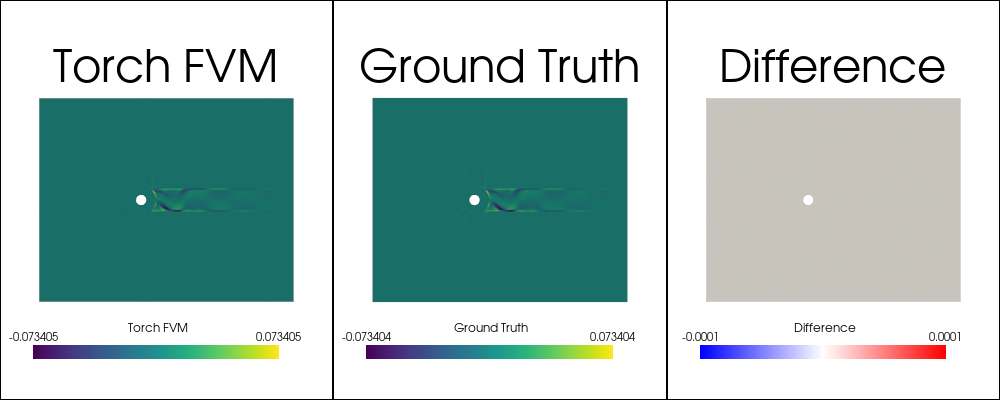

In [54]:
plot_comparison(vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction=new_grad_correction2,
                    ground_truth = cell_total_flux_correction,
                    clims3=[-0.0001,0.0001]
                    )

Success!

## Operator Correction

In [55]:
mesh.correction_method = 'Over-Relaxed'
mesh._calculate_correction_vectors(method = mesh.correction_method)

In [56]:
laplacian = Laplacian_Operator.caclulate(mesh, U_gt.unsqueeze(0).unsqueeze(0), correction_method=mesh.correction_method,
                             gradient_field=gradient)

In [ ]:
def plot_comparison(mesh, file_location, file_name, 
                    ground_truth, prediction, i,
                    point_label=None, j=None, interactive = True, 
                    clims = None, clims2 = None, clims3 = None, 
                    show_mesh =False, percent=False,
                    zoom=False):
    if j is None:
        j = i 

    plotter = pv.Plotter(shape=(1, 3),
                         off_screen= not interactive, 
                         window_size=[1000, 400])
    #get copy of mesh
    mesh_for_plotting = mesh.copy(deep=True)
    mesh_for_plotting['Torch FVM'] = prediction[:,i]
    mesh_for_plotting['Ground Truth'] = ground_truth[:,j]
    if percent:
        mesh_for_plotting['Difference'] = (ground_truth[:,j] - prediction[:,i])/(ground_truth[:,j] + 1e-12)
    else:
        mesh_for_plotting['Difference'] = ground_truth[:,j] - prediction[:,i]

    # comparison colour map:
    berlin_cmap = plt.get_cmap("bwr")
    if clims is None:
        abs_max = np.max(np.abs(mesh_for_plotting['Torch FVM']))
        clims = [-abs_max, abs_max]
    
    if clims2 is None:
        abs_max = np.max(np.abs(mesh_for_plotting['Ground Truth']))
        clims2 = [-abs_max, abs_max]
    
    if clims3 is None:
        abs_max = np.max(np.abs(mesh_for_plotting['Difference']))
        clims3 = [-abs_max, abs_max]



    # Plot scalar1 in the first subplot
    plotter.subplot(0, 0)
    actor = plotter.add_mesh(mesh_for_plotting, 
                     scalars='Torch FVM', 
                     cmap='viridis', 
                     clim=clims, 
                     show_scalar_bar=False, 
                     show_edges=show_mesh, 
                     edge_opacity=0.25,
                     copy_mesh=True)
    plotter.add_title("Torch FVM")
    plotter.view_xy()
    # Custom scalar bar
    scalar_bar(plotter, 'Torch FVM')

    # Plot scalar2 in the second subplot
    plotter.subplot(0, 1)
    actor = plotter.add_mesh(mesh_for_plotting, 
                     scalars='Ground Truth', 
                     cmap='viridis', 
                     clim=clims2, 
                     show_scalar_bar=False, 
                     show_edges=show_mesh, 
                     edge_opacity=0.25,
                     copy_mesh=True)
    plotter.add_title("Ground Truth")
    plotter.view_xy()
    # Custom scalar bar
    scalar_bar(plotter, 'Ground Truth')


    # Plot scalar3 in the third subplot
    plotter.subplot(0, 2)
    actor = plotter.add_mesh(mesh_for_plotting, 
                     scalars='Difference', 
                     cmap=berlin_cmap, 
                     clim=clims3, 
                     show_scalar_bar=False, 
                     show_edges=show_mesh, 
                     edge_opacity=0.25,
                     copy_mesh=True)
    plotter.add_title(f"Difference")
    plotter.view_xy()
    # Custom scalar bar
    scalar_bar(plotter, "Difference")
    
    if point_label:
        plotter.add_point_labels(
        [point_label],           # list of points (even if it's one)
        ["Top of Sphere"], # corresponding labels
        point_size=10,
        font_size=12,
        text_color="red"
    )
    
    plotter.camera.zoom(1.4)
    if zoom:
        camera_pos = [  (0.044014283620703254, -0.02407829133705193, 11.125520284676016),  # Camera position (X, Y, Z)
                        (0.0, 0.0, 0.0),  # Focal point (center of the mesh)
                        (0.0, 1.0, 0.0)]  # View-up direction (Z-up)
            
        plotter.camera_position = camera_pos

    # Display the plot
    if interactive:
        plotter.show()
    else:
        plotter.show(auto_close=False)
        
        os.makedirs(file_location, exist_ok=True)
        print('saving in directory: ', file_location)
        plt.imsave(f"{file_location}/{file_name.replace('/','_')}.png", plotter.image)
        plotter.close()

with boundary non-orthogonal correctors

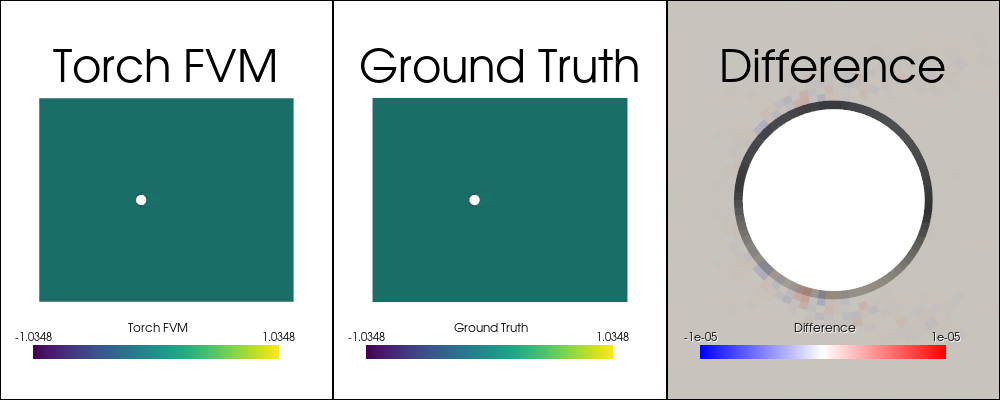

In [ ]:
plot_comparison(vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction=laplacian[0,0,...].numpy()*nu,
                    ground_truth = lapU_corrected,
                    clims3=[-0.00001,0.00001],
                    zoom=True
                    )

Without boundary non-orthogonal correctors

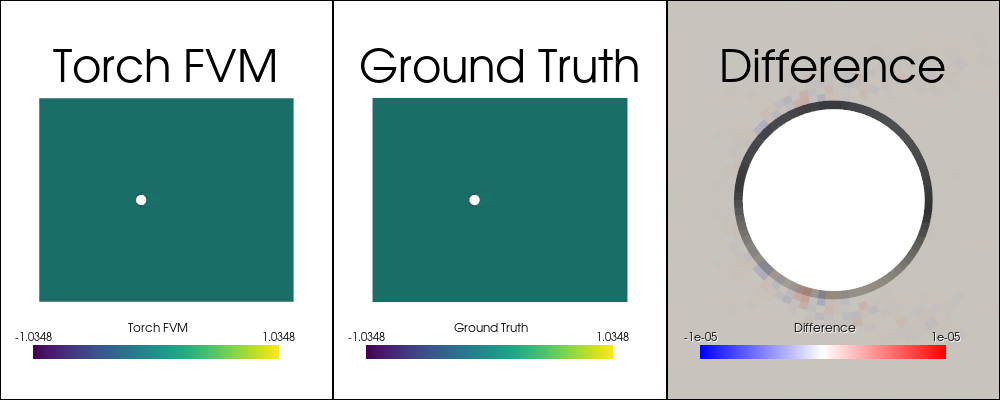

In [ ]:
plot_comparison(vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction=laplacian[0,0,...].numpy()*nu,
                    ground_truth = lapU_corrected,
                    clims3=[-0.00001,0.00001],
                    zoom=True
                    )